[MLP] ep1/1200 train=7.636e+02 val=7.209e+02 vio_tr=2.523e+01 vio_va=2.467e+01
[MLP] ep100/1200 train=7.409e+02 val=6.990e+02 vio_tr=2.463e+01 vio_va=2.408e+01
[MLP] ep200/1200 train=7.155e+02 val=6.745e+02 vio_tr=2.395e+01 vio_va=2.340e+01
[MLP] ep300/1200 train=6.831e+02 val=6.432e+02 vio_tr=2.327e+01 vio_va=2.273e+01
[MLP] ep400/1200 train=6.403e+02 val=6.020e+02 vio_tr=2.365e+01 vio_va=2.308e+01
[MLP] ep500/1200 train=5.859e+02 val=5.496e+02 vio_tr=2.823e+01 vio_va=2.756e+01
[MLP] ep600/1200 train=5.217e+02 val=4.879e+02 vio_tr=3.225e+01 vio_va=3.147e+01
[MLP] ep700/1200 train=4.500e+02 val=4.192e+02 vio_tr=2.946e+01 vio_va=2.871e+01
[MLP] ep800/1200 train=3.746e+02 val=3.472e+02 vio_tr=2.428e+01 vio_va=2.360e+01
[MLP] ep900/1200 train=3.013e+02 val=2.775e+02 vio_tr=1.976e+01 vio_va=1.913e+01
[MLP] ep1000/1200 train=2.351e+02 val=2.151e+02 vio_tr=1.582e+01 vio_va=1.523e+01
[MLP] ep1100/1200 train=1.797e+02 val=1.633e+02 vio_tr=1.213e+01 vio_va=1.158e+01
[MLP] ep1200/1200 train=1.36

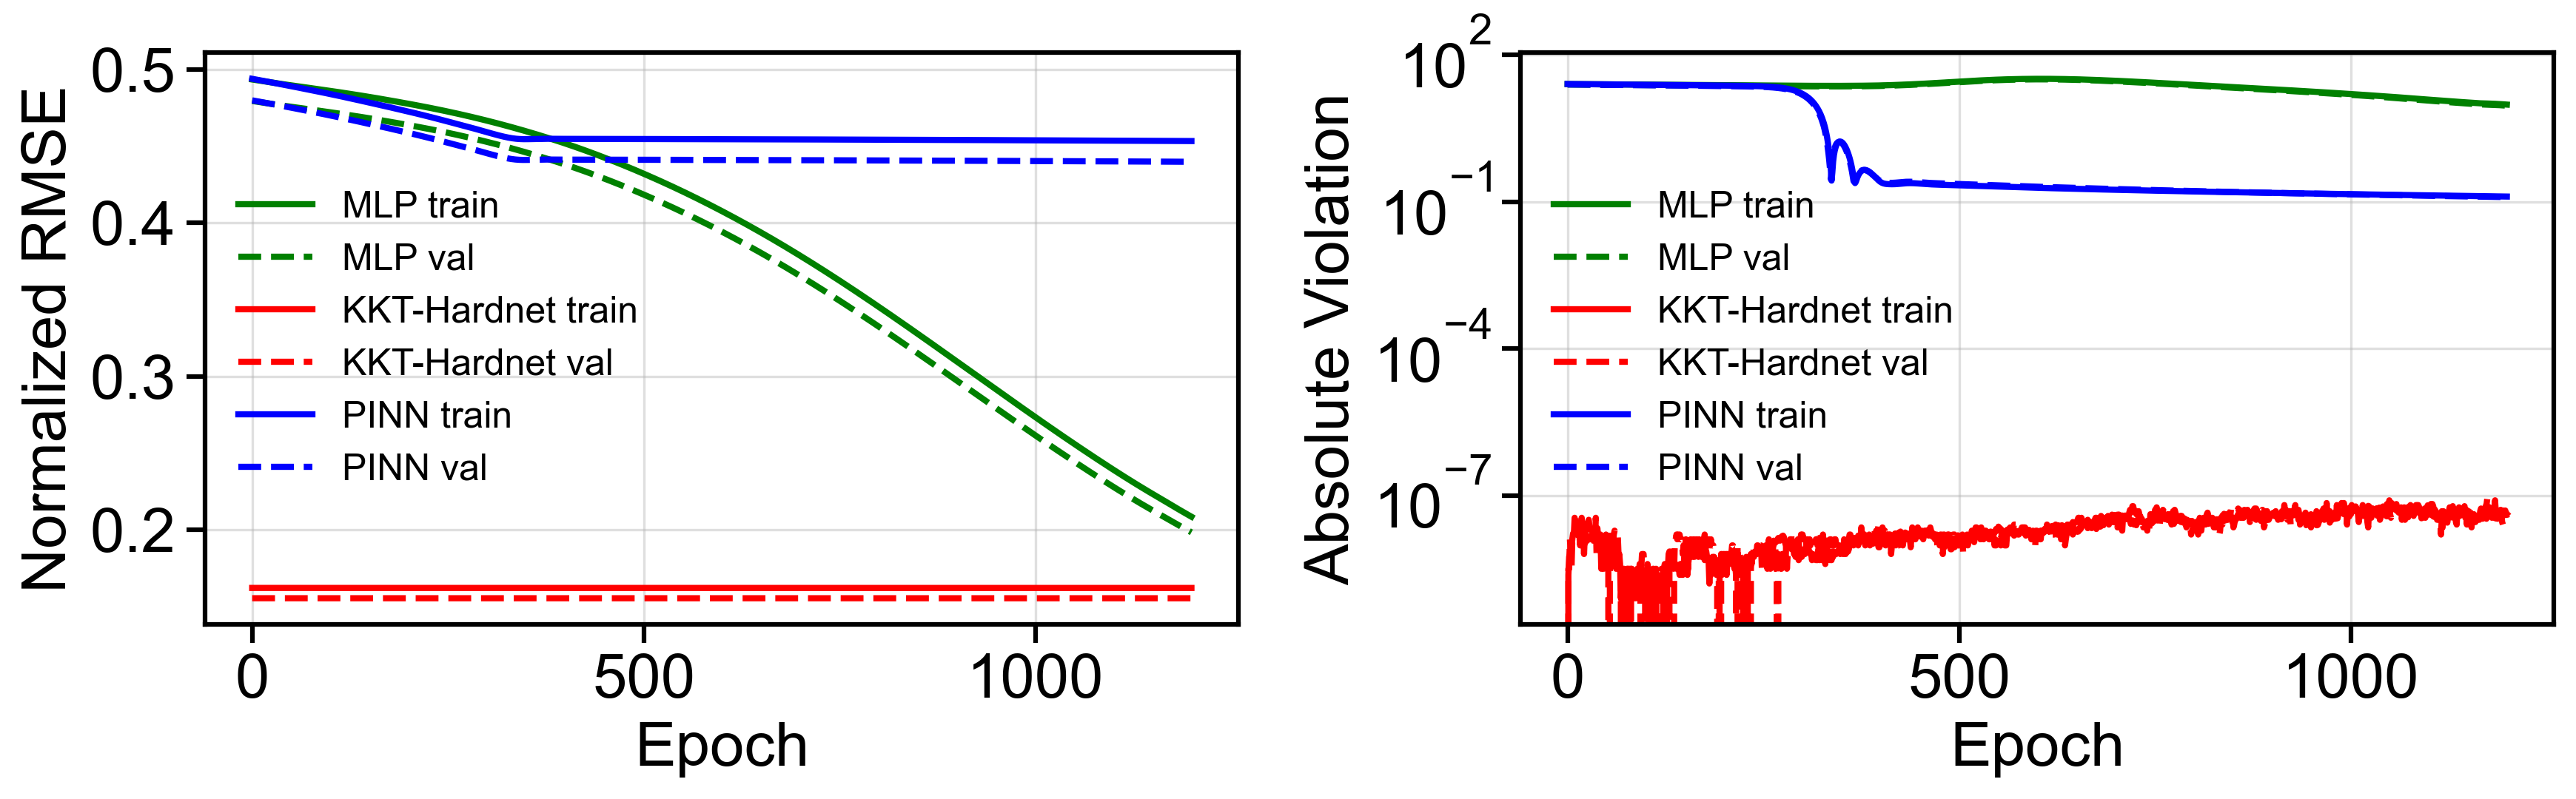

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1234)
np.random.seed(1234)

def gen(n):
    x = np.random.uniform(1, 2, (n, 1)).astype(np.float32)
    y1 = 8 * x**3 + 5
    y2 = 2 * x - 1
    return torch.from_numpy(x), torch.from_numpy(np.concatenate([y1, y2], axis=1))

# Data generation
Xtr, Ytr = gen(1200)
Xva, Yva = gen(300)


def c_of(x):
    x4 = torch.log(torch.clamp_min(x, 1e-6))
    x3 = 2 * x4
    x2 = torch.exp(x3)
    x1 = torch.exp(x4)
    return 12*x2 - 6*x1 + 6

# Models
class VanillaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        return self.net(x)

class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        return self.net(x)

class FullNewtonLayerKKT(nn.Module):
    """
    - Hard projection via 11 x 11 KKT system on [y1…y7, z1…z3, λ], 
    - Armijo backtracking,
    - Tikhonov regularization for ill-conditioning.
    """
    def __init__(self, K=30, tol=1e-10, max_backtrack=10, c=1e-4):
        super().__init__()
        self.K             = K
        self.tol           = tol
        self.max_backtrack = max_backtrack
        self.c             = c

    def forward(self, x, y0):
        device = x.device
        bsz    = x.size(0)

        # initial guesses =  NN output
        y1 = y0[:, :1].clone()
        y2 = y0[:, 1:2].clone()

        # transformations
        y3 = y2**3
        y6 = y2**2
        y5 = torch.log(torch.clamp_min(y2, 1e-6))
        y4 = 3*y5
        y7 = 2*y5
        z1 = torch.exp(y5)
        z2 = torch.exp(y4)
        z3 = torch.exp(y7)

        # initialize dual
        lam = torch.zeros_like(y1)

        # Newton‐KKT iterations
        for _ in range(self.K):
            c_x = c_of(x)

            # 11 residuals
            F1  = y1 - y0[:, :1] + lam
            F2  = y2 - y0[:, 1:2] - 3*lam*y6
            F3  = y7 - 2*y5
            F4  = y6 - z3
            F5  = z3 - torch.exp(y7)
            F6  = y1 - y3 - c_x
            F7  = y4 - 3*y5
            F8  = y2 - z1
            F9  = y3 - z2
            F10 = z1 - torch.exp(y5)
            F11 = z2 - torch.exp(y4)

            F    = torch.cat([F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11], dim=1)
            maxF = F.abs().max()
            if maxF < self.tol:
                break

            # Jacobian [bsz × 11 × 11]
            J = torch.zeros(bsz, 11, 11, device=device)

            # eqn1
            J[:,0,0]  = 1;     J[:,0,10] = 1
            
            # eqn2
            J[:,1,1]  = 1
            J[:,1,5]  = -3 * lam.view(-1)
            J[:,1,10] = -3 * y6.view(-1)
            
            # eqn3
            J[:,2,6]  = 1;     J[:,2,4]  = -2
            
            # eqn4
            J[:,3,5]  = 1;     J[:,3,9]  = -1
            
            # eqn5
            J[:,4,9]  = 1;     J[:,4,6]  = -torch.exp(y7).view(-1)
            
            # eqn6
            J[:,5,0]  = 1;     J[:,5,2]  = -1
            
            # eqn7
            J[:,6,3]  = 1;     J[:,6,4]  = -3
            
            # eqn8
            J[:,7,1]  = 1;     J[:,7,7]  = -1
            
            # eqn9
            J[:,8,2]  = 1;     J[:,8,8]  = -1
            
            # eqn10
            J[:,9,7]  = 1;     J[:,9,4]  = -torch.exp(y5).view(-1)
            
            # eqn11
            J[:,10,8] = 1;     J[:,10,3] = -torch.exp(y4).view(-1)

            # regularized normal equations
            JT        = J.transpose(-2, -1)                         # [B×11×11]
            JTJ       = JT @ J                                      # [B×11×11]
            eps       = 1e-6                                        # Tikhonov small constant
            I         = torch.eye(JTJ.size(-1), device=device)      # [11×11]
            A         = JTJ + eps * I.unsqueeze(0)                  # [B×11×11]
            b         = JT @ (-F.unsqueeze(-1))                     # [B×11×1]
            delta     = torch.linalg.solve(A, b).squeeze(-1)         # [B×11]


            # backtracking Armijo line-search
            alpha = 1.0
            for _bt in range(self.max_backtrack):
                # update
                y1n  = y1  + alpha*delta[:, 0:1]
                y2n  = y2  + alpha*delta[:, 1:2]
                y3n  = y3  + alpha*delta[:, 2:3]
                y4n  = y4  + alpha*delta[:, 3:4]
                y5n  = y5  + alpha*delta[:, 4:5]
                y6n  = y6  + alpha*delta[:, 5:6]
                y7n  = y7  + alpha*delta[:, 6:7]
                z1n  = z1  + alpha*delta[:, 7:8]
                z2n  = z2  + alpha*delta[:, 8:9]
                z3n  = z3  + alpha*delta[:, 9:10]
                lamn = lam + alpha*delta[:,10:11]

                # compute residuals
                F1n  = y1n - y0[:, :1] + lamn
                F2n  = y2n - y0[:, 1:2] - 3*lamn*y6n
                F3n  = y7n - 2*y5n
                F4n  = y6n - z3n
                F5n  = z3n - torch.exp(y7n)
                F6n  = y1n - y3n - c_x
                F7n  = y4n - 3*y5n
                F8n  = y2n - z1n
                F9n  = y3n - z2n
                F10n = z1n - torch.exp(y5n)
                F11n = z2n - torch.exp(y4n)

                Fnew = torch.cat([F1n,F2n,F3n,F4n,F5n,F6n,F7n,F8n,F9n,F10n,F11n], dim=1)
                if Fnew.abs().max() <= (1 - self.c*alpha)*maxF:
                    break
                alpha *= 0.5  # reduce step size

            
            y1,y2,y3,y4,y5,y6,y7 = y1n,y2n,y3n,y4n,y5n,y6n,y7n
            z1,z2,z3,lam       = z1n,z2n,z3n,lamn

        return torch.cat([y1, y2], dim=1)


class ConstrainedNN_KKT(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
        # Add the KKT projection layer
        self.proj = FullNewtonLayerKKT()

    def forward(self, x):
        y0 = self.base(x)
        return self.proj(x, y0)

# Helpers for Training
def violation_abs(model, X):
    with torch.no_grad():
        Yp = model(X)
        r  = Yp[:,0] - Yp[:,1]**3 - c_of(X).squeeze(1)
        return torch.mean(r.abs()).item()

def mse_mape(Yh, Y):
    mse  = torch.mean((Yh - Y)**2).item()
    mape = torch.mean((Yh - Y).abs()/Y.abs().clamp_min(1e-12)).item()
    return mse, mape

def train_log(model, Xtr, Ytr, Xva, Yva, epochs=1200, lr=1e-4, tag=""):
    opt, mse = optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    logs = ([],[],[],[])
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        Yp = model(Xtr)
        L  = mse(Yp, Ytr)
        L.backward()
        opt.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            Lv  = mse(model(Xva), Yva).item()
            vtr = violation_abs(model, Xtr)
            vva = violation_abs(model, Xva)

        logs[0].append(torch.sqrt(L).item())
        logs[1].append(np.sqrt(Lv))
        logs[2].append(vtr)
        logs[3].append(vva)

        if ep==1 or ep%100==0:
            print(f"[{tag}] ep{ep}/{epochs} train={L:.3e} val={Lv:.3e}"
                  f" vio_tr={vtr:.3e} vio_va={vva:.3e}")
    return [np.array(x) for x in logs]

def train_pinn(model, Xtr, Ytr, Xva, Yva,
               epochs=1200, lr=1e-4, lam=100., tag="PINN"):
    opt, mse = optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    logs = ([],[],[],[])
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        Yp = model(Xtr)
        Lm = mse(Yp, Ytr)
        r  = Yp[:,0] - Yp[:,1]**3 - c_of(Xtr).squeeze(1)
        L  = Lm + lam*(r**2).mean()
        L.backward()
        opt.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            Yv  = model(Xva)
            Lv  = mse(Yv, Yva).item()
            vtr = r.abs().mean().item()
            rv  = Yv[:,0] - Yv[:,1]**3 - c_of(Xva).squeeze(1)
            vva = rv.abs().mean().item()

        logs[0].append(torch.sqrt(Lm).item())
        logs[1].append(np.sqrt(Lv))
        logs[2].append(vtr)
        logs[3].append(vva)

        if ep==1 or ep%100==0:
            print(f"[{tag}] ep{ep}/{epochs} train={Lm:.3e} val={Lv:.3e}"
                  f" vio_tr={vtr:.3e} vio_va={vva:.3e}")
    return [np.array(x) for x in logs]


# Instantiate models
mlp = VanillaMLP()
kkt = ConstrainedNN_KKT()
pnn = PINN()

rmse_tr_mlp, rmse_va_mlp, vio_tr_mlp, vio_va_mlp = train_log(mlp, Xtr,Ytr, Xva,Yva, tag="MLP")
rmse_tr_kkt, rmse_va_kkt, vio_tr_kkt, vio_va_kkt = train_log(kkt, Xtr,Ytr, Xva,Yva, tag="KKT-Hardnet")
rmse_tr_pnn, rmse_va_pnn, vio_tr_pnn, vio_va_pnn = train_pinn(pnn, Xtr,Ytr, Xva,Yva, tag="PINN")

# Normalize RMSE
Yall = torch.cat([Ytr, Yva], dim=0)
yrange = (Yall.max(0)[0] - Yall.min(0)[0]).max().item()

norm_tr_mlp  = rmse_tr_mlp  / yrange
norm_va_mlp  = rmse_va_mlp  / yrange
norm_tr_kkt  = rmse_tr_kkt  / yrange
norm_va_kkt  = rmse_va_kkt  / yrange
norm_tr_pnn  = rmse_tr_pnn  / yrange
norm_va_pnn  = rmse_va_pnn  / yrange

# Final Metrics
print("\n=== FINAL METRICS ===")
print("model   train-MSE train-MAPE |vio|   || val-MSE val-MAPE |vio|")
for name, net in [("MLP",mlp),("KKT-Hardnet",kkt),("PINN",pnn)]:
    mse_tr, mape_tr = mse_mape(net(Xtr), Ytr)
    mse_va, mape_va = mse_mape(net(Xva), Yva)
    vtr, vva       = violation_abs(net, Xtr), violation_abs(net, Xva)
    print(f"{name:6s}: {mse_tr:8.3e} {mape_tr:8.3e} {vtr:8.2e} || {mse_va:8.3e} {mape_va:8.3e} {vva:8.2e}")


# Plotting
plt.rc("font", family="Arial")
plt.rcParams.update({
    "font.size":20,
    "axes.linewidth":1.5,
    "xtick.major.size":6, "xtick.major.width":1.5,
    "ytick.major.size":6, "ytick.major.width":1.5,
    "legend.frameon":False
})

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4),dpi=300)

# Normalized RMSE
ax1.plot(norm_tr_mlp,  label="MLP train",  linewidth=2, color='g')
ax1.plot(norm_va_mlp,  "--", label="MLP val",    linewidth=2, color='g')
ax1.plot(norm_tr_kkt,  label="KKT-Hardnet train",linewidth=2, color = 'r')
ax1.plot(norm_va_kkt,  "--", label="KKT-Hardnet val",  linewidth=2, color = 'r')
ax1.plot(norm_tr_pnn,  label="PINN train", linewidth=2, color='b')
ax1.plot(norm_va_pnn,  "--", label="PINN val",   linewidth=2, color='b')
ax1.set(xlabel="Epoch", ylabel="Normalized RMSE")
ax1.grid("--", alpha=0.4)
ax1.legend(fontsize=12)

# Violation
ax2.plot(vio_tr_mlp,  label="MLP train",  linewidth=2, color='g')
ax2.plot(vio_va_mlp,  "--", label="MLP val",    linewidth=2, color='g')
ax2.plot(vio_tr_kkt,  label="KKT-Hardnet train",linewidth=2, color = 'r')
ax2.plot(vio_va_kkt,  "--", label="KKT-Hardnet val",  linewidth=2, color = 'r')
ax2.plot(vio_tr_pnn,  label="PINN train", linewidth=2, color='b')
ax2.plot(vio_va_pnn,  "--", label="PINN val",   linewidth=2, color='b')
ax2.set(xlabel="Epoch", ylabel="Absolute Violation")
ax2.set_yscale("log")
ax2.grid("--", alpha=0.4)
ax2.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Unrolled vs. IFT

In [ ]:
# kkt_projection_ift_vs_unrolled.py
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --------------------------
# Setup
# --------------------------
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Data gen and constraint c(x) = 12 x^2 - 6 x + 6
# --------------------------
def gen(n):
    x = np.random.uniform(1, 2, (n, 1)).astype(np.float32)
    y1 = 8 * x**3 + 5
    y2 = 2 * x - 1
    return torch.from_numpy(x), torch.from_numpy(np.concatenate([y1, y2], axis=1))

def c_of(x):
    # NOTE: written in the same "transformed" way as your original code
    x4 = torch.log(torch.clamp_min(x, 1e-6))
    x3 = 2 * x4
    x2 = torch.exp(x3)      # x^2
    x1 = torch.exp(x4)      # x
    return 12*x2 - 6*x1 + 6

def dc_dx(x):
    # derivative of c(x) = 24 x - 6
    return 24.0 * x - 6.0

# --------------------------
# Models
# --------------------------
class VanillaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        return self.net(x)

# --------------------------
# Unrolled Newton KKT projection layer (your original style)
# --------------------------
class FullNewtonLayerKKT_Unrolled(nn.Module):
    """
    Unrolled Newton with Armijo + Tikhonov (autograd through iterations)
    """
    def __init__(self, K=30, tol=1e-10, max_backtrack=10, c=1e-4):
        super().__init__()
        self.K             = K
        self.tol           = tol
        self.max_backtrack = max_backtrack
        self.c             = c

    def forward(self, x, y0):
        device = x.device
        bsz    = x.size(0)

        # initialize from NN output
        y1 = y0[:, :1].clone()
        y2 = y0[:, 1:2].clone()

        # aux variables
        y3 = y2**3
        y6 = y2**2
        y5 = torch.log(torch.clamp_min(y2, 1e-6))
        y4 = 3*y5
        y7 = 2*y5
        z1 = torch.exp(y5)
        z2 = torch.exp(y4)
        z3 = torch.exp(y7)
        lam = torch.zeros_like(y1)

        for _ in range(self.K):
            c_x = c_of(x)

            F1  = y1 - y0[:, :1] + lam
            F2  = y2 - y0[:, 1:2] - 3*lam*y6
            F3  = y7 - 2*y5
            F4  = y6 - z3
            F5  = z3 - torch.exp(y7)
            F6  = y1 - y3 - c_x
            F7  = y4 - 3*y5
            F8  = y2 - z1
            F9  = y3 - z2
            F10 = z1 - torch.exp(y5)
            F11 = z2 - torch.exp(y4)
            F   = torch.cat([F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11], dim=1)
            maxF = F.abs().max()
            if maxF < self.tol:
                break

            # Build Jacobian (B x 11 x 11)
            J = torch.zeros(bsz, 11, 11, device=device)
            # eqn1
            J[:,0,0]  = 1;     J[:,0,10] = 1
            # eqn2
            J[:,1,1]  = 1
            J[:,1,5]  = -3 * lam.view(-1)
            J[:,1,10] = -3 * y6.view(-1)
            # eqn3
            J[:,2,6]  = 1;     J[:,2,4]  = -2
            # eqn4
            J[:,3,5]  = 1;     J[:,3,9]  = -1
            # eqn5
            J[:,4,9]  = 1;     J[:,4,6]  = -torch.exp(y7).view(-1)
            # eqn6
            J[:,5,0]  = 1;     J[:,5,2]  = -1
            # eqn7
            J[:,6,3]  = 1;     J[:,6,4]  = -3
            # eqn8
            J[:,7,1]  = 1;     J[:,7,7]  = -1
            # eqn9
            J[:,8,2]  = 1;     J[:,8,8]  = -1
            # eqn10
            J[:,9,7]  = 1;     J[:,9,4]  = -torch.exp(y5).view(-1)
            # eqn11
            J[:,10,8] = 1;     J[:,10,3] = -torch.exp(y4).view(-1)

            # regularized normal equations
            JT   = J.transpose(-2, -1)
            JTJ  = JT @ J
            eps  = 1e-6
            I    = torch.eye(JTJ.size(-1), device=device).unsqueeze(0)
            A    = JTJ + eps * I
            b    = JT @ (-F.unsqueeze(-1))
            delta = torch.linalg.solve(A, b).squeeze(-1)

            # backtracking
            alpha = 1.0
            for _bt in range(self.max_backtrack):
                y1n  = y1  + alpha*delta[:, 0:1]
                y2n  = y2  + alpha*delta[:, 1:2]
                y3n  = y3  + alpha*delta[:, 2:3]
                y4n  = y4  + alpha*delta[:, 3:4]
                y5n  = y5  + alpha*delta[:, 4:5]
                y6n  = y6  + alpha*delta[:, 5:6]
                y7n  = y7  + alpha*delta[:, 6:7]
                z1n  = z1  + alpha*delta[:, 7:8]
                z2n  = z2  + alpha*delta[:, 8:9]
                z3n  = z3  + alpha*delta[:, 9:10]
                lamn = lam + alpha*delta[:,10:11]

                F1n  = y1n - y0[:, :1] + lamn
                F2n  = y2n - y0[:, 1:2] - 3*lamn*y6n
                F3n  = y7n - 2*y5n
                F4n  = y6n - z3n
                F5n  = z3n - torch.exp(y7n)
                F6n  = y1n - y3n - c_of(x)
                F7n  = y4n - 3*y5n
                F8n  = y2n - z1n
                F9n  = y3n - z2n
                F10n = z1n - torch.exp(y5n)
                F11n = z2n - torch.exp(y4n)
                Fnew = torch.cat([F1n,F2n,F3n,F4n,F5n,F6n,F7n,F8n,F9n,F10n,F11n], dim=1)

                if Fnew.abs().max() <= (1 - self.c*alpha)*maxF:
                    break
                alpha *= 0.5

            y1,y2,y3,y4,y5,y6,y7 = y1n,y2n,y3n,y4n,y5n,y6n,y7n
            z1,z2,z3,lam         = z1n,z2n,z3n,lamn

        return torch.cat([y1, y2], dim=1)

class ConstrainedNN_KKT_Unrolled(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
        self.proj = FullNewtonLayerKKT_Unrolled()
    def forward(self, x):
        y0 = self.base(x)
        return self.proj(x, y0)

# --------------------------
# Implicit differentiation version
# --------------------------
class KKTProjectionIFTFn(torch.autograd.Function):
    """
    Forward: run the same Newton solver to get u* (solution).
    Backward: implicit differentiation:
        (dF/du)^T w = dL/du   solve for w
        dL/dtheta = + VJP_base([w0, w1])   because F1, F2 depend on y0 with -I, and extra minus cancels
        dL/dx     = - (dF/dx)^T w   (only F6 depends on x via -c(x))
    We form (dF/du) explicitly at the solution (tiny 11x11 per sample).
    """
    @staticmethod
    def forward(ctx, x, y0, K, tol, max_backtrack, c_armijo):
        with torch.enable_grad():  # Forward uses autograd-friendly ops
            layer = FullNewtonLayerKKT_Unrolled(K=K, tol=tol, max_backtrack=max_backtrack, c=c_armijo)
            y = layer(x, y0)

        # Save for backward: x, y0, and the full solution's needed stuff to reconstruct J at u*
        ctx.save_for_backward(x, y0, y)
        ctx.K = K
        ctx.tol = tol
        ctx.max_backtrack = max_backtrack
        ctx.c_armijo = c_armijo
        return y

    @staticmethod
    def backward(ctx, grad_out):
        x, y0, y = ctx.saved_tensors
        bsz = x.size(0)
        device = x.device

        # Recreate the solution's auxiliary variables (at the converged y)
        y1 = y[:, :1]
        y2 = y[:, 1:2]
        y3 = y2**3
        y6 = y2**2
        y5 = torch.log(torch.clamp_min(y2, 1e-6))
        y4 = 3*y5
        y7 = 2*y5
        z1 = torch.exp(y5)
        z2 = torch.exp(y4)
        z3 = torch.exp(y7)
        # Recover lambda approximately from KKT stationarity eqn1: F1 = y1 - y0[:,:1] + lam = 0
        lam = (y0[:, :1] - y1)  # lam = y0[:,0] - y1  (since F1=0)

        # Build Jacobian dF/du at the solution (B x 11 x 11)
        J = torch.zeros(bsz, 11, 11, device=device)
        # eqn1
        J[:,0,0]  = 1;     J[:,0,10] = 1
        # eqn2
        J[:,1,1]  = 1
        J[:,1,5]  = -3 * lam.view(-1)
        J[:,1,10] = -3 * y6.view(-1)
        # eqn3
        J[:,2,6]  = 1;     J[:,2,4]  = -2
        # eqn4
        J[:,3,5]  = 1;     J[:,3,9]  = -1
        # eqn5
        J[:,4,9]  = 1;     J[:,4,6]  = -torch.exp(y7).view(-1)
        # eqn6
        J[:,5,0]  = 1;     J[:,5,2]  = -1
        # eqn7
        J[:,6,3]  = 1;     J[:,6,4]  = -3
        # eqn8
        J[:,7,1]  = 1;     J[:,7,7]  = -1
        # eqn9
        J[:,8,2]  = 1;     J[:,8,8]  = -1
        # eqn10
        J[:,9,7]  = 1;     J[:,9,4]  = -torch.exp(y5).view(-1)
        # eqn11
        J[:,10,8] = 1;     J[:,10,3] = -torch.exp(y4).view(-1)

        # We need dL/du for u = [y1,y2,y3,y4,y5,y6,y7,z1,z2,z3,lam]
        # grad_out is dL/dy where y=[y1,y2]; so map to u-space: only first two slots get grads
        g = torch.zeros(bsz, 11, device=device)
        g[:,0] = grad_out[:,0]  # dL/dy1
        g[:,1] = grad_out[:,1]  # dL/dy2

        # Solve (J^T) w = g  for each batch
        JT = J.transpose(-2, -1)
        w = torch.linalg.solve(JT, g.unsqueeze(-1)).squeeze(-1)  # (B x 11)

        # Grad wrt y0 (through F1,F2 dependence):  dL/dy0 = [w0, w1]
        grad_y0 = torch.zeros_like(y0)
        grad_y0[:,0:1] = w[:,0:1]
        grad_y0[:,1:2] = w[:,1:2]

        # Grad wrt x: only F6 depends on x via -c(x).
        # dF6/dx = - c'(x)  =>  dL/dx = - (dF/dx)^T w = - (dF6/dx)^T * w6 = c'(x) * w6
        w6 = w[:,5:6]
        grad_x = dc_dx(x) * w6

        # No direct params here; the base net gets gradients via grad_y0 through autograd
        return grad_x, grad_y0, None, None, None, None

class FullNewtonLayerKKT_Implicit(nn.Module):
    def __init__(self, K=30, tol=1e-10, max_backtrack=10, c=1e-4):
        super().__init__()
        self.K = K; self.tol = tol; self.max_backtrack = max_backtrack; self.c = c
    def forward(self, x, y0):
        return KKTProjectionIFTFn.apply(x, y0, self.K, self.tol, self.max_backtrack, self.c)

class ConstrainedNN_KKT_Implicit(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
        self.proj = FullNewtonLayerKKT_Implicit()
    def forward(self, x):
        y0 = self.base(x)
        return self.proj(x, y0)

# --------------------------
# PINN (soft constraint) if you want it for comparison
# --------------------------
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,64), nn.ReLU(),
            nn.Linear(64,64), nn.ReLU(),
            nn.Linear(64,2)
        )
    def forward(self, x):
        return self.net(x)

# --------------------------
# Training helpers
# --------------------------
@torch.no_grad()
def violation_abs(model, X):
    Yp = model(X)
    r  = Yp[:,0] - Yp[:,1]**3 - c_of(X).squeeze(1)
    return torch.mean(r.abs()).item()

def mse_mape(Yh, Y):
    mse  = torch.mean((Yh - Y)**2).item()
    mape = torch.mean((Yh - Y).abs()/Y.abs().clamp_min(1e-12)).item()
    return mse, mape

def train_supervised(model, Xtr, Ytr, Xva, Yva, epochs=800, lr=1e-4, tag=""):
    opt, mse = optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    logs = ([],[],[],[])
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad(set_to_none=True)
        Yp = model(Xtr)
        L  = mse(Yp, Ytr)
        L.backward()
        opt.step()

        # Eval
        model.eval()
        with torch.no_grad():
            Lv  = mse(model(Xva), Yva).item()
            vtr = violation_abs(model, Xtr)
            vva = violation_abs(model, Xva)

        logs[0].append(torch.sqrt(L).item())
        logs[1].append(np.sqrt(Lv))
        logs[2].append(vtr)
        logs[3].append(vva)

        if ep==1 or ep%100==0:
            print(f"[{tag}] ep{ep}/{epochs} train={L:.3e} val={Lv:.3e} | vio_tr={vtr:.3e} vio_va={vva:.3e}")
    return [np.array(x) for x in logs]

def train_pinn(model, Xtr, Ytr, Xva, Yva, epochs=800, lr=1e-4, lam=100., tag="PINN"):
    opt, mse = optim.Adam(model.parameters(), lr=lr), nn.MSELoss()
    logs = ([],[],[],[])
    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad(set_to_none=True)
        Yp = model(Xtr)
        Lm = mse(Yp, Ytr)
        r  = Yp[:,0] - Yp[:,1]**3 - c_of(Xtr).squeeze(1)
        L  = Lm + lam*(r**2).mean()
        L.backward()
        opt.step()

        model.eval()
        with torch.no_grad():
            Yv  = model(Xva)
            Lv  = mse(Yv, Yva).item()
            vtr = r.abs().mean().item()
            rv  = Yv[:,0] - Yv[:,1]**3 - c_of(Xva).squeeze(1)
            vva = rv.abs().mean().item()

        logs[0].append(torch.sqrt(Lm).item())
        logs[1].append(np.sqrt(Lv))
        logs[2].append(vtr)
        logs[3].append(vva)

        if ep==1 or ep%100==0:
            print(f"[{tag}] ep{ep}/{epochs} train={Lm:.3e} val={Lv:.3e} | vio_tr={vtr:.3e} vio_va={vva:.3e}")
    return [np.array(x) for x in logs]

# --------------------------
# Main
# --------------------------
def main():
    # Data
    Xtr, Ytr = gen(1200)
    Xva, Yva = gen(300)
    Xtr = Xtr.to(device); Ytr = Ytr.to(device)
    Xva = Xva.to(device); Yva = Yva.to(device)

    # Models
    mlp = VanillaMLP().to(device)
    kkt_unrolled = ConstrainedNN_KKT_Unrolled().to(device)
    kkt_ift = ConstrainedNN_KKT_Implicit().to(device)
    pinn = PINN().to(device)

    # Train
    rmse_tr_mlp,  rmse_va_mlp,  vio_tr_mlp,  vio_va_mlp  = train_supervised(mlp, Xtr,Ytr, Xva,Yva, tag="MLP")
    rmse_tr_unr,  rmse_va_unr,  vio_tr_unr,  vio_va_unr  = train_supervised(kkt_unrolled, Xtr,Ytr, Xva,Yva, tag="KKT-Hardnet (unrolled)")
    rmse_tr_ift,  rmse_va_ift,  vio_tr_ift,  vio_va_ift  = train_supervised(kkt_ift, Xtr,Ytr, Xva,Yva, tag="KKT-IFT (implicit)")
    rmse_tr_pnn,  rmse_va_pnn,  vio_tr_pnn,  vio_va_pnn  = train_pinn(pinn, Xtr,Ytr, Xva,Yva, tag="PINN")

    # Normalize RMSE by overall range (match your plotting)
    Yall = torch.cat([Ytr, Yva], dim=0)
    yrange = (Yall.max(0)[0] - Yall.min(0)[0]).max().item()

    norm_tr_mlp  = rmse_tr_mlp  / yrange
    norm_va_mlp  = rmse_va_mlp  / yrange
    norm_tr_unr  = rmse_tr_unr  / yrange
    norm_va_unr  = rmse_va_unr  / yrange
    norm_tr_ift  = rmse_tr_ift  / yrange
    norm_va_ift  = rmse_va_ift  / yrange
    norm_tr_pnn  = rmse_tr_pnn  / yrange
    norm_va_pnn  = rmse_va_pnn  / yrange

    # Final metrics
    print("\n=== FINAL METRICS ===")
    print("model                    train-MSE  train-MAPE    |vio|   ||   val-MSE   val-MAPE    |vio|")
    for name, net in [("MLP", mlp),
                      ("KKT-Hardnet (unrolled)", kkt_unrolled),
                      ("KKT-IFT (implicit)", kkt_ift),
                      ("PINN", pinn)]:
        with torch.no_grad():
            mse_tr, mape_tr = mse_mape(net(Xtr), Ytr)
            mse_va, mape_va = mse_mape(net(Xva), Yva)
            vtr, vva        = violation_abs(net, Xtr), violation_abs(net, Xva)
        print(f"{name:24s}: {mse_tr:10.3e} {mape_tr:10.3e} {vtr:9.2e} || {mse_va:10.3e} {mape_va:10.3e} {vva:9.2e}")

    # --------------------------
    # Plotting
    # --------------------------
    plt.rc("font", family="Arial")
    plt.rcParams.update({
        "font.size":16,
        "axes.linewidth":1.5,
        "xtick.major.size":6, "xtick.major.width":1.5,
        "ytick.major.size":6, "ytick.major.width":1.5,
        "legend.frameon":False
    })

    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4),dpi=140)

    # Normalized RMSE
    ax1.plot(norm_tr_mlp,  label="MLP train",  linewidth=2)
    ax1.plot(norm_va_mlp,  "--", label="MLP val", linewidth=2)
    ax1.plot(norm_tr_unr,  label="KKT-Unrolled train", linewidth=2)
    ax1.plot(norm_va_unr,  "--", label="KKT-Unrolled val", linewidth=2)
    ax1.plot(norm_tr_ift,  label="KKT-IFT train", linewidth=2)
    ax1.plot(norm_va_ift,  "--", label="KKT-IFT val", linewidth=2)
    ax1.plot(norm_tr_pnn,  label="PINN train", linewidth=2)
    ax1.plot(norm_va_pnn,  "--", label="PINN val", linewidth=2)
    ax1.set(xlabel="Epoch", ylabel="Normalized RMSE")
    ax1.grid("--", alpha=0.4)
    ax1.legend(fontsize=10)

    # Violation
    ax2.plot(vio_tr_mlp,  label="MLP train",  linewidth=2)
    ax2.plot(vio_va_mlp,  "--", label="MLP val", linewidth=2)
    ax2.plot(vio_tr_unr,  label="KKT-Unrolled train", linewidth=2)
    ax2.plot(vio_va_unr,  "--", label="KKT-Unrolled val", linewidth=2)
    ax2.plot(vio_tr_ift,  label="KKT-IFT train", linewidth=2)
    ax2.plot(vio_va_ift,  "--", label="KKT-IFT val", linewidth=2)
    ax2.plot(vio_tr_pnn,  label="PINN train", linewidth=2)
    ax2.plot(vio_va_pnn,  "--", label="PINN val", linewidth=2)
    ax2.set(xlabel="Epoch", ylabel="Absolute Violation")
    ax2.set_yscale("log")
    ax2.grid("--", alpha=0.4)
    ax2.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
